**Generative Adversarial Networks**

Usar redes neurais para gerar novas imagens.

Criar imagens automaticamente.

Composto por:
- Gerador: Gera as imagens;
- Discriminador: Acessa as imagens criadas e informa se elas são parecidas com as originais.

Ambos iniciam do zero, os dois devem aprender sozinhos. O gerador é uma rede que recebe números aleatórios.
Discriminador é uma rede que recebe exemplos e contraexemplos, problema de classificação binária, ele retorna uma probabilidade de ser ou não a classe esperada.

As GANs preocupam-se apenas em gerar novas imagens

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [2]:
(X_treinamento, y_treinamento),(_,_) = tf.keras.datasets.mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
X_treinamento.shape

(60000, 28, 28)

In [10]:
y_treinamento.shape

(60000,)

7


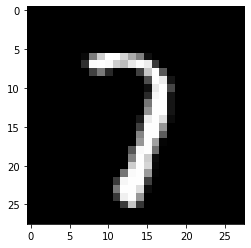

In [15]:
i = np.random.randint(0, X_treinamento.shape[0])
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap='gray');

In [16]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float')

In [17]:
X_treinamento.shape

(60000, 28, 28, 1)

In [18]:
# Normalizando a imagem
# Para GANs recomenda-se usar a escala -1 até 1 
X_treinamento = (X_treinamento - 127.5) / 127.5

In [19]:
buffer_size = X_treinamento.shape[0]
batch_size = 256 # Técnica: Mini batch gradient descent

In [20]:
buffer_size / batch_size

234.375

In [21]:
# Convertendo a imagem para o tipo do tensorflow
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

**Construção do gerador**

Entrada: Números aleatórios

Saída: Imagem

In [45]:
def criar_gerador():
  
  rede = tf.keras.Sequential()

  rede.add(layers.Dense(7 * 7 * 256, # 12544 neurônios
                        use_bias = False,
                        input_shape = (100,) # Número de números aleatórios de entrada
                        ) 
          ) 
  rede.add(layers.BatchNormalization())
  rede.add(layers.LeakyReLU()) # Número negativo = número negativo * 0.001, número positivo = número positivo
  rede.add(layers.Reshape((7,7,256)))

  # Conv2D -> Diminui a dimensionalidade
  # Conv2DTranspose -> Aumenta a dimensionalidade
  rede.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias = False))
  rede.add(layers.BatchNormalization())
  rede.add(layers.LeakyReLU())

  rede.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias = False, strides = (2,2)))
  rede.add(layers.BatchNormalization())
  rede.add(layers.LeakyReLU())

  rede.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias = False, strides = (2,2), activation = 'tanh' # Retorna valores entre -1 e 1
  ))

  rede.summary()

  return rede

In [46]:
gerador = criar_gerador()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_7 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 7, 7, 128)       

In [47]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_6_input')>

In [48]:
ruido = tf.random.normal([1, 100])

In [49]:
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.1131276 , -1.1830213 , -0.6792213 ,  0.72900003, -0.53219   ,
         0.83163923,  0.540032  , -1.616006  , -0.47970393,  0.5638488 ,
        -1.0446665 , -0.87205577,  0.03976629, -0.3449169 , -1.9501152 ,
        -1.7586024 ,  1.2957051 ,  0.43386588,  0.5371723 ,  0.12660947,
        -1.0059048 , -0.14526933, -0.00558333, -0.95934343,  0.780961  ,
         1.2502761 ,  0.14654908, -0.6807248 ,  1.1026896 ,  2.2055714 ,
        -1.8465363 ,  1.8588526 , -0.8937026 ,  1.1919101 ,  1.644395  ,
        -1.072031  ,  1.5100087 , -1.3817618 ,  0.5577823 ,  0.9002848 ,
        -0.13931926,  1.491516  ,  1.4345335 , -1.7977306 ,  1.224952  ,
         0.9187026 , -0.64930207, -2.127502  , -1.2990324 ,  0.31155974,
        -1.1546977 ,  0.07962796,  0.5495174 ,  0.17541744,  0.69619316,
         0.14845182, -0.96748054,  0.51150316,  2.053142  ,  2.1635847 ,
        -1.0554788 , -0.5201949 ,  0.8399305 ,  0.11191642, -1.2257915 ,
 

In [50]:
imagem_gerada = gerador(ruido, training = False)

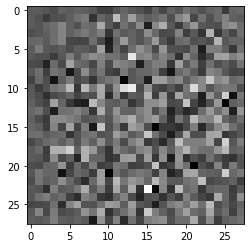

In [51]:
imagem_gerada.shape

plt.imshow(imagem_gerada[0,:,:,0], cmap='gray')

In [52]:
# Gerador: 100 números aleatórios -> Rede -> imagem 

**Construção do discriminador**

In [53]:
def criar_discriminador():
  rede = tf.keras.Sequential()

  rede.add(layers.Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=[28,28,1]))
  rede.add(layers.LeakyReLU())
  rede.add(layers.Dropout(0.3))

  rede.add(layers.Conv2D(128, (5,5), strides = (2,2), padding='same'))
  rede.add(layers.LeakyReLU())
  rede.add(layers.Dropout(0.3))

  rede.add(layers.Flatten())
  rede.add(layers.Dense(1))

  rede.summary()

  return rede

In [54]:
discriminador = criar_discriminador()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [55]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_2_input')>

In [56]:
discriminador(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00176607]], dtype=float32)>

**Cálculo do erro**

Quando a função de ativação não é informada, indica que está trabalhando com os dados brutos da rede.

Valores sem aplicação da função de ativação são chamados de Logits

In [58]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [59]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), # Compara vetor com valores = 1, quanto mais próximo de um mais próxima da imagem real está a imagem gerada
                            expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss

  return total_loss

In [60]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [64]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001)

**Treinamento da GAN**

In [62]:
X_treinamento

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

In [63]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [75]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Gera as imagens
    imagens_geradas = gerador(ruido, training = True)
    # Manda as imagens para o discriminador
    expected_output = discriminador(imagens, training = True)
    fake_output = discriminador(imagens_geradas, training = True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [76]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [77]:
def treinar_gran(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      treinamento(imagem_batch)
    
    print('Época: ', epoca + 1)
    imagens_geradas = gerador(imagens_teste, training = False)
    fig = plt.figure(figsize=(10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(imagens_geradas[i,:,:,0] * 127.5 + 127.5, cmap='gray');
      plt.axis('off')
    plt.show()


Época:  1


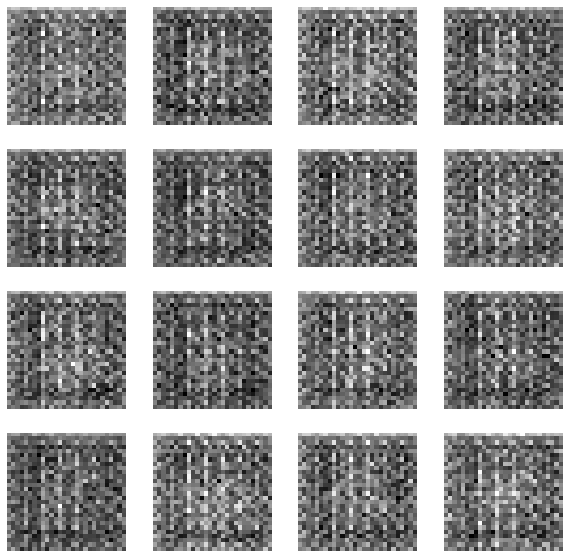

Época:  2


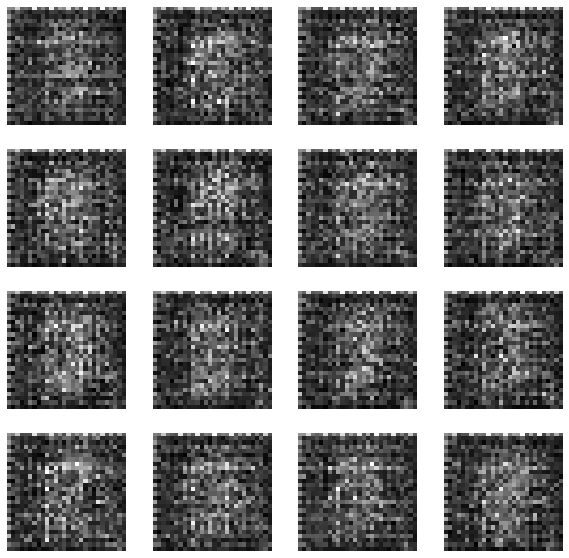

Época:  3


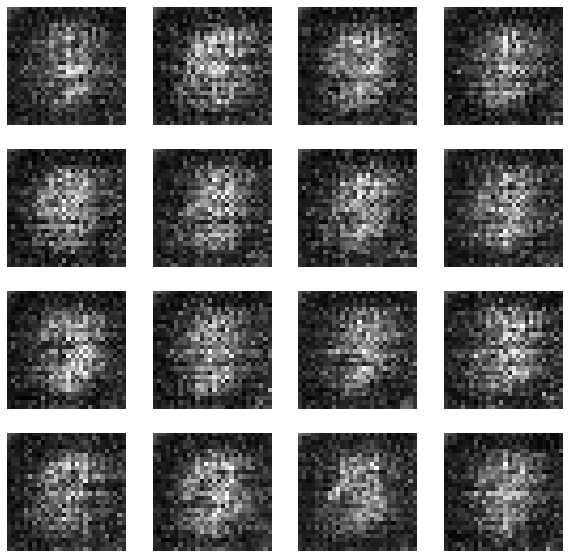

Época:  4


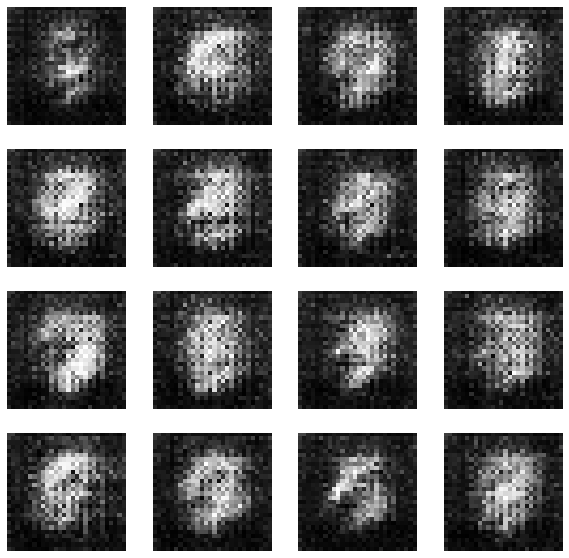

Época:  5


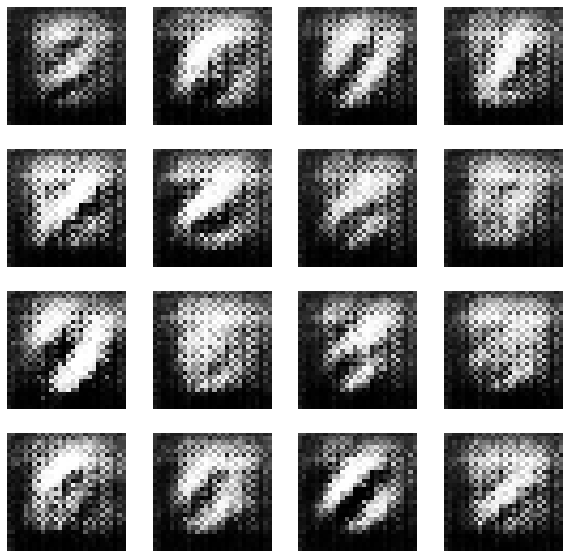

Época:  6


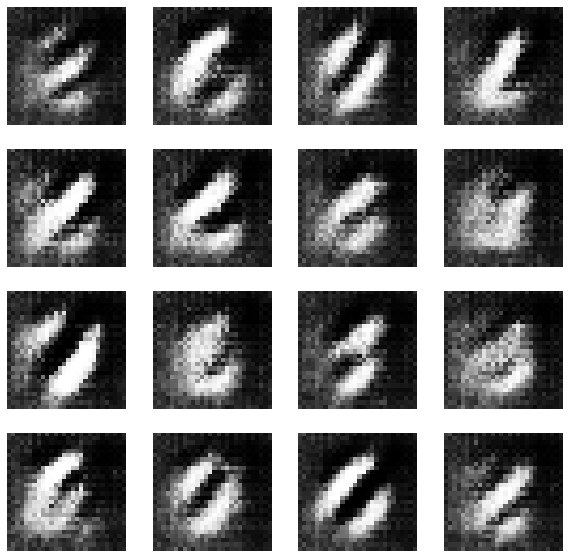

Época:  7


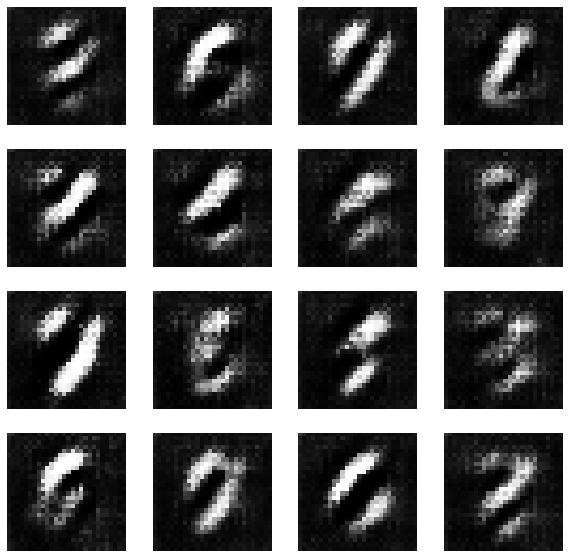

Época:  8


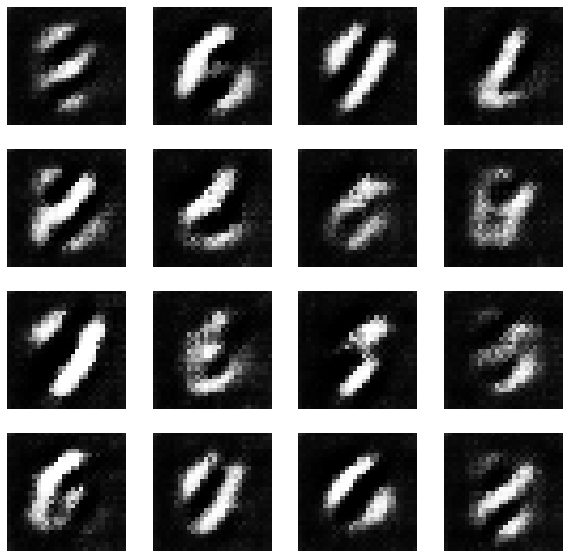

Época:  9


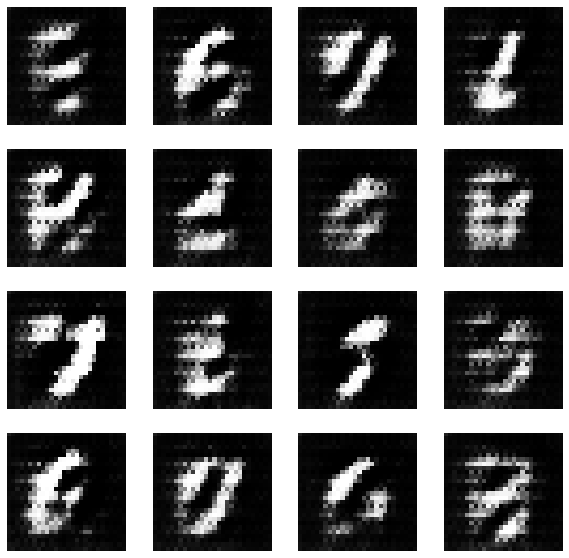

Época:  10


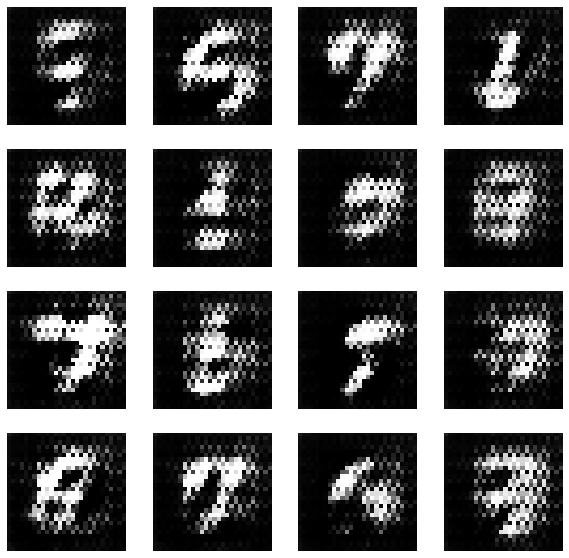

Época:  11


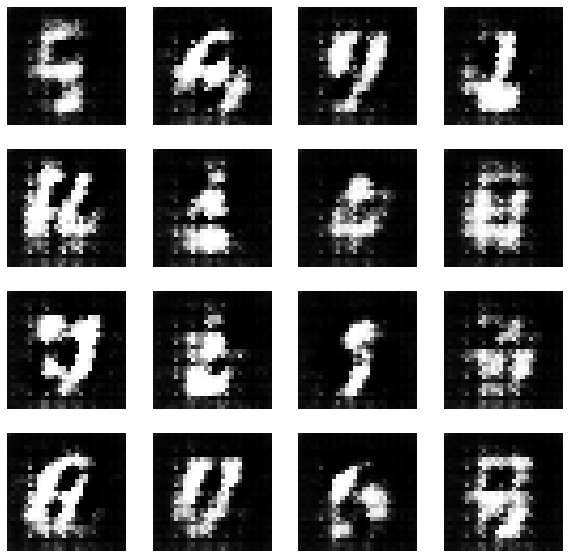

Época:  12


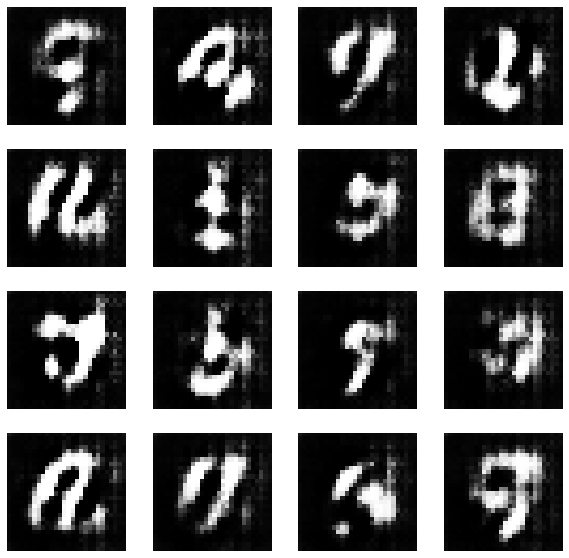

Época:  13


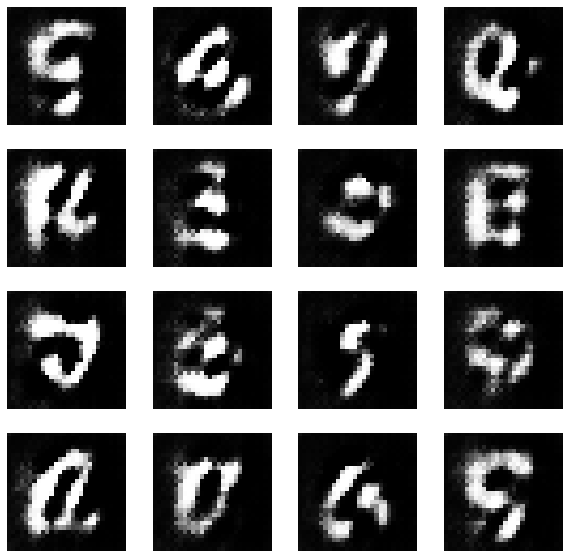

Época:  14


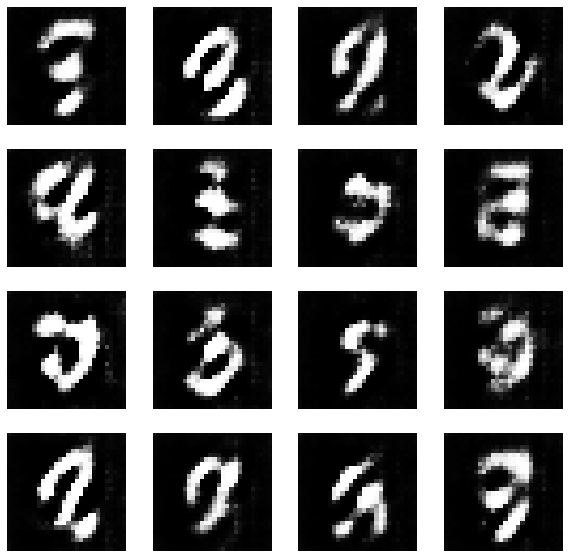

Época:  15


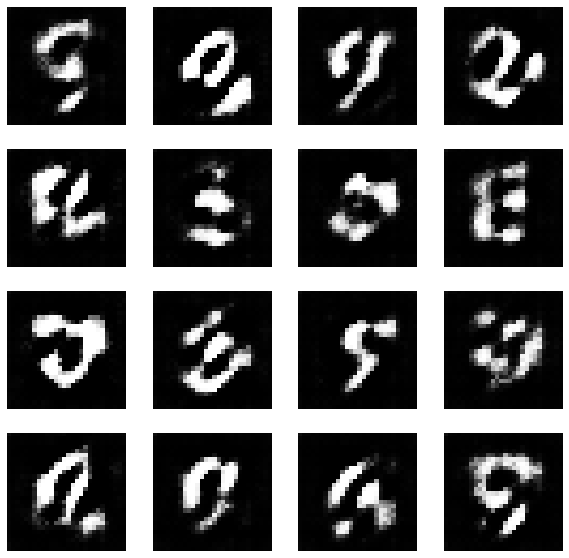

Época:  16


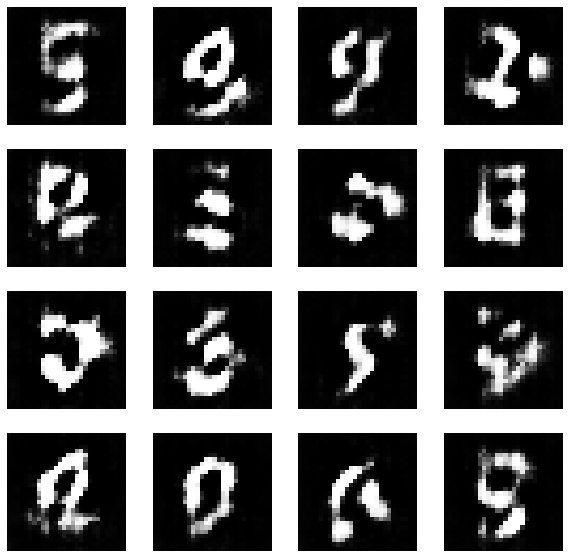

Época:  17


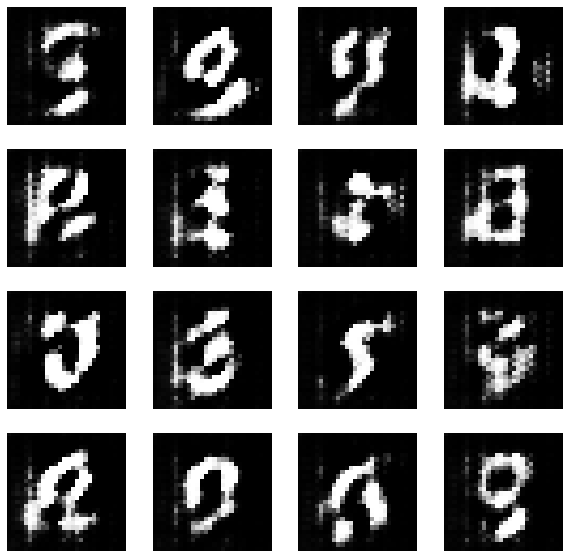

Época:  18


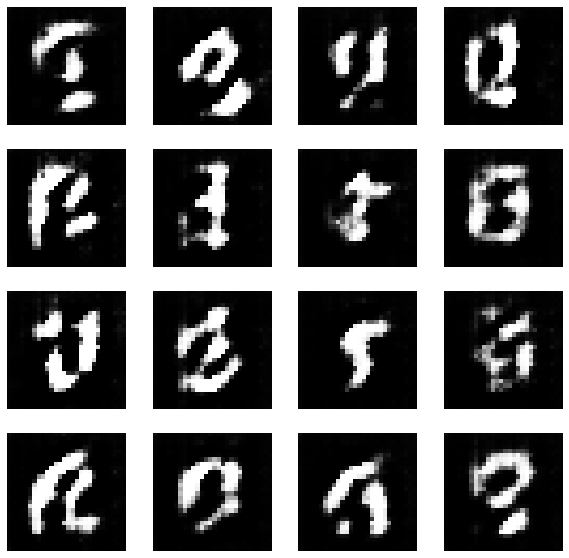

Época:  19


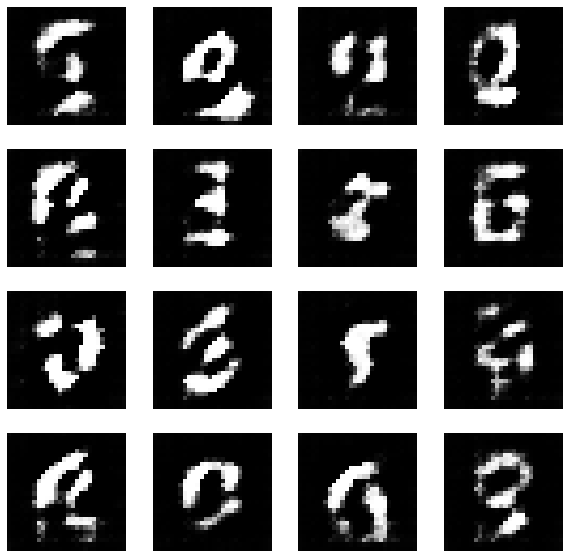

Época:  20


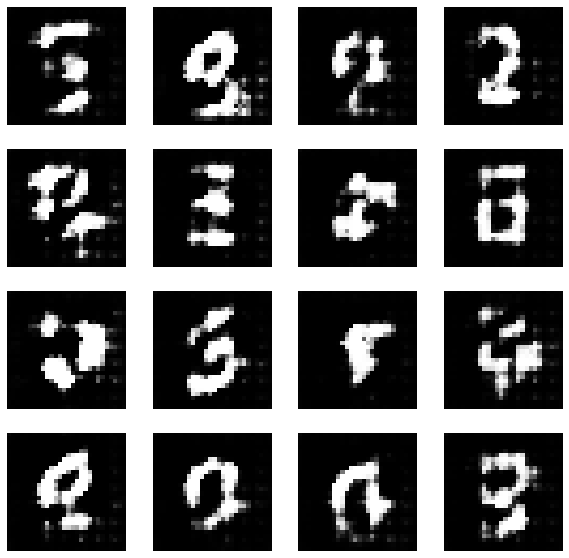

Época:  21


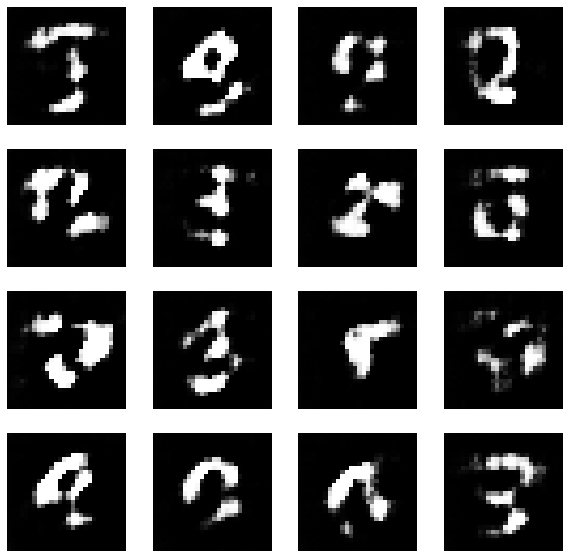

Época:  22


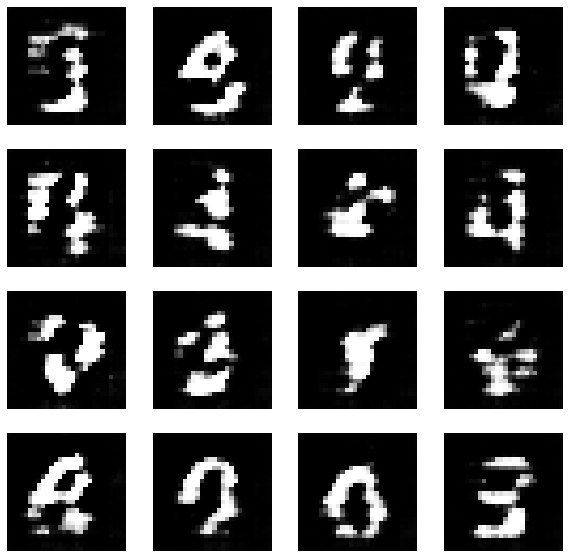

Época:  23


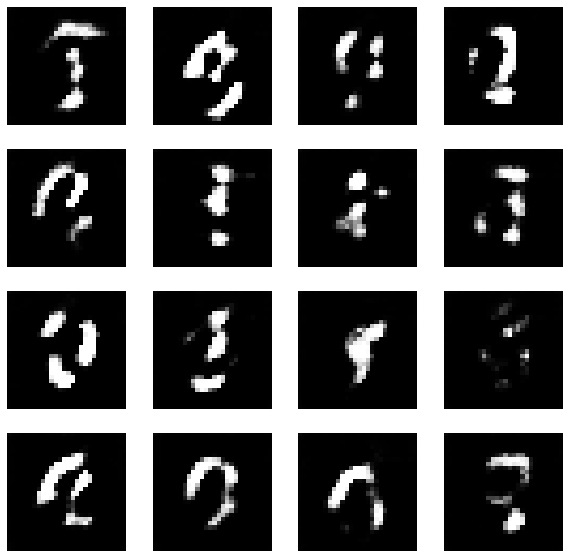

Época:  24


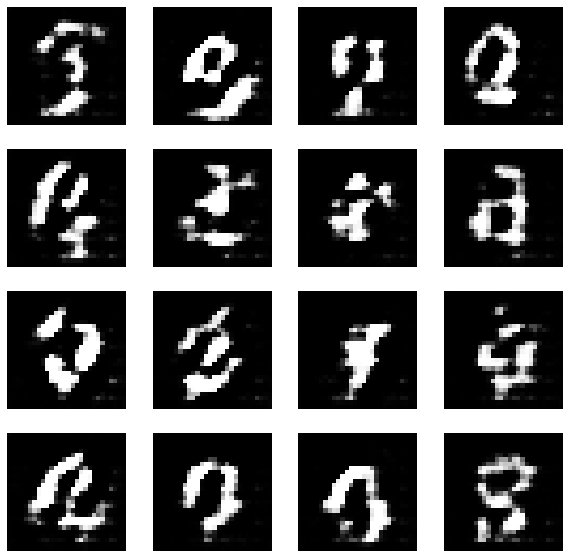

Época:  25


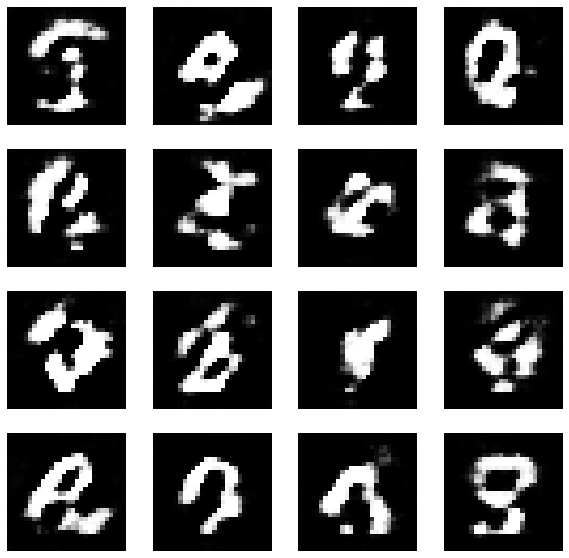

Época:  26


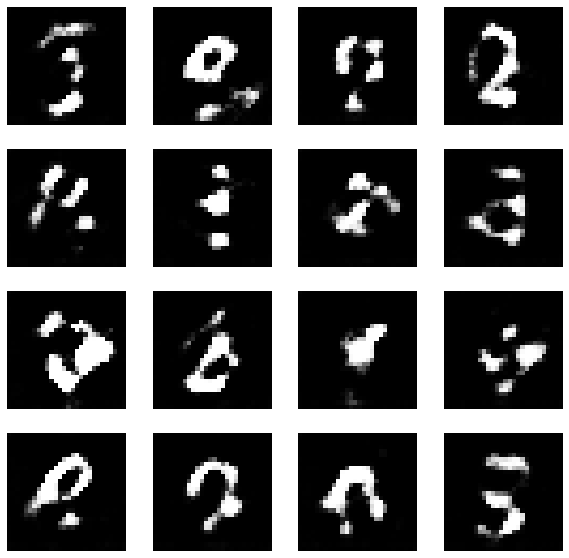

Época:  27


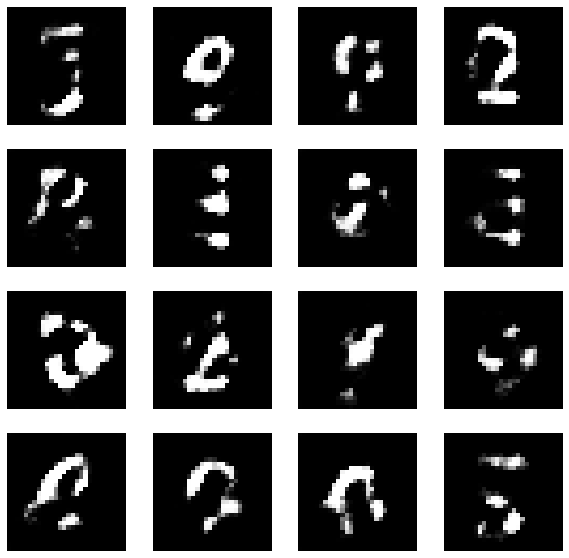

Época:  28


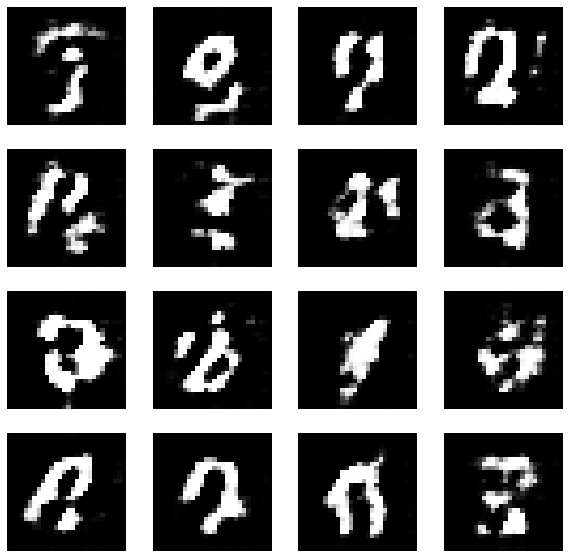

Época:  29


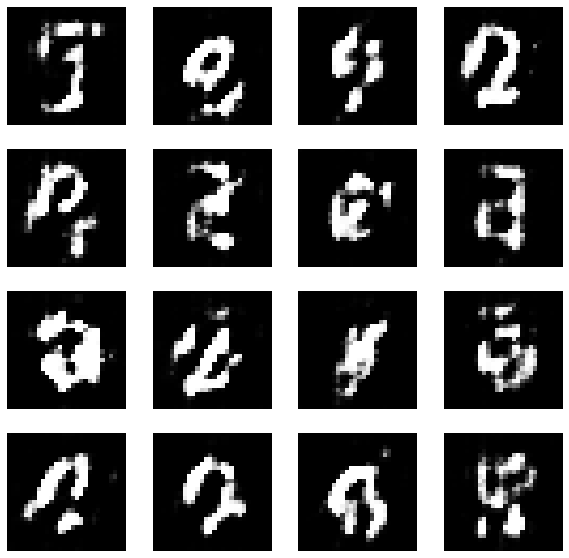

Época:  30


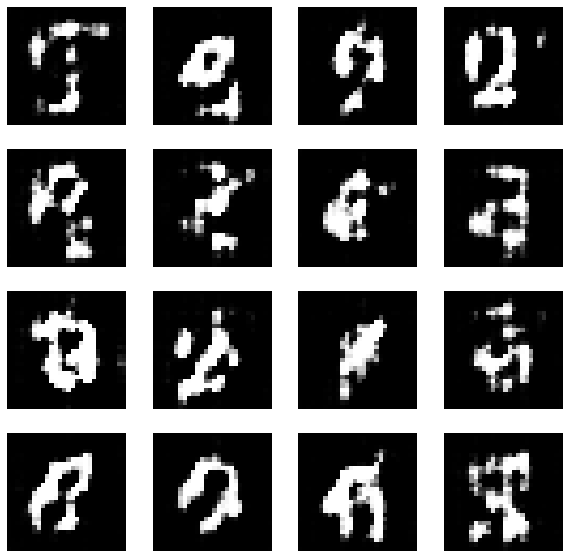

Época:  31


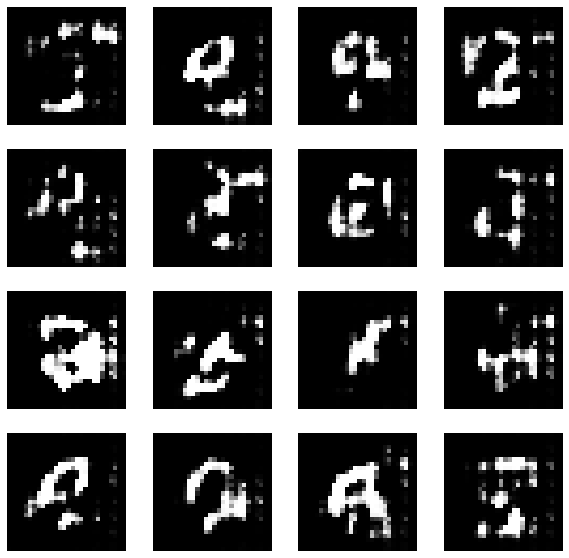

Época:  32


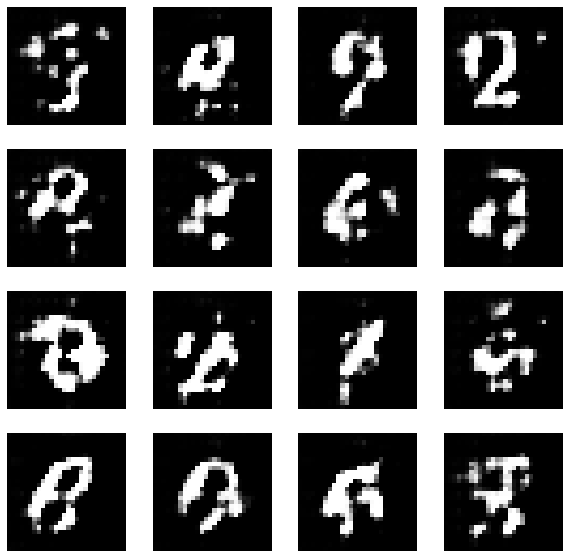

Época:  33


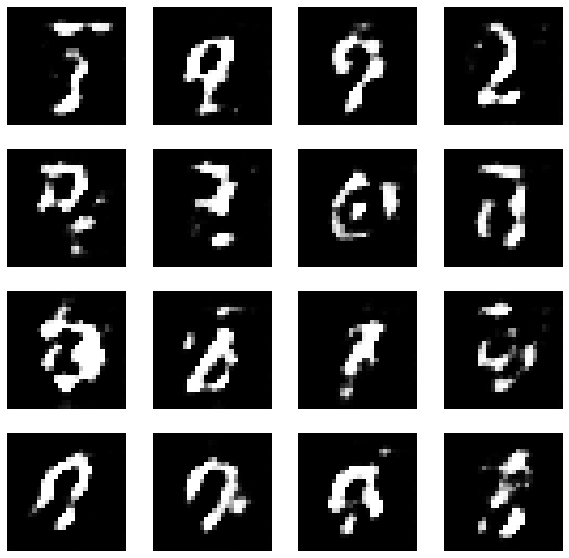

Época:  34


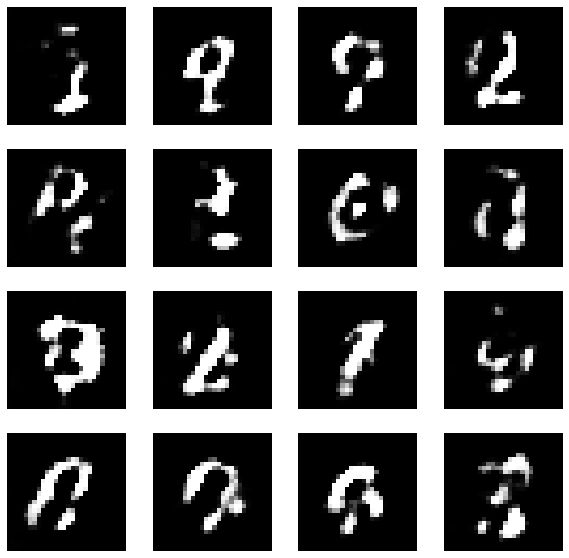

Época:  35


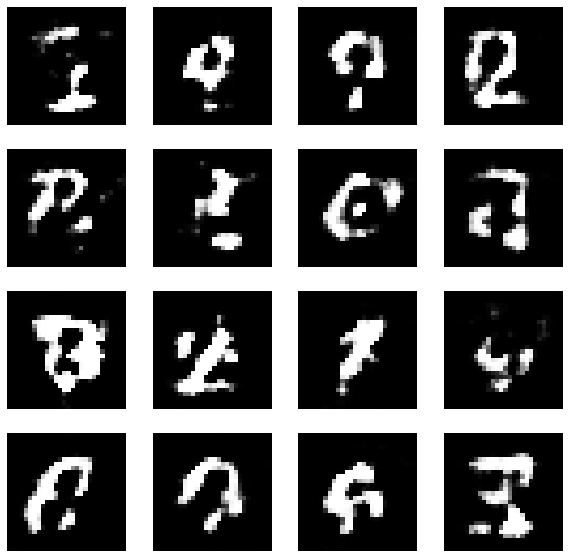

Época:  36


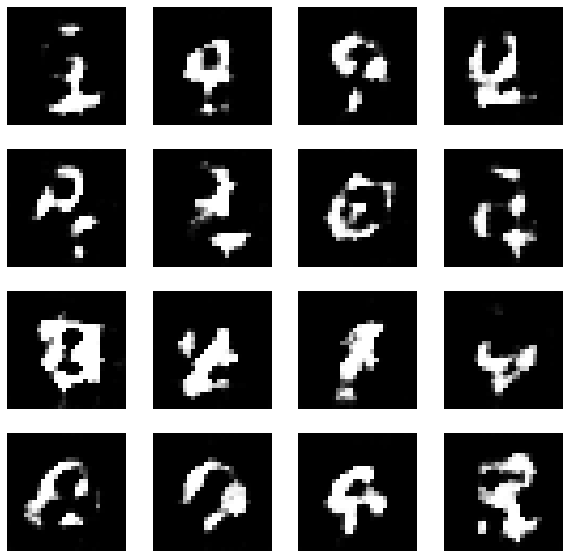

Época:  37


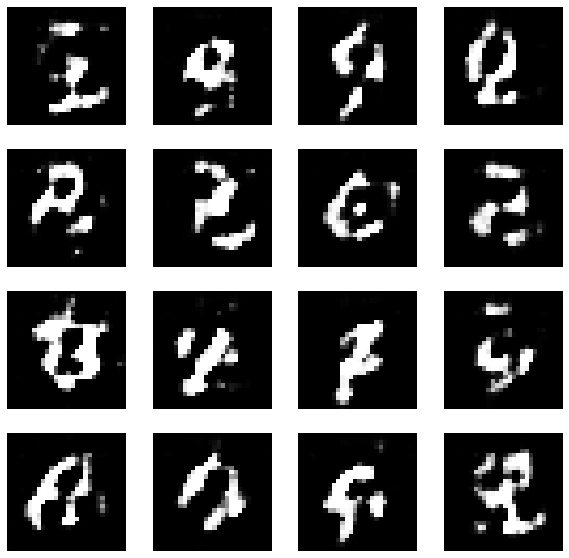

Época:  38


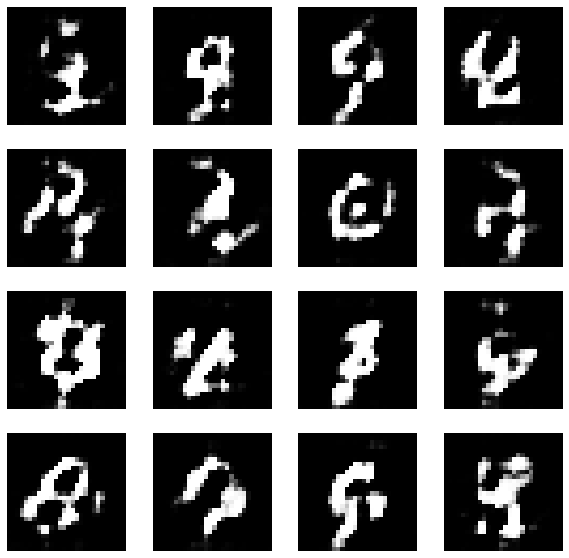

Época:  39


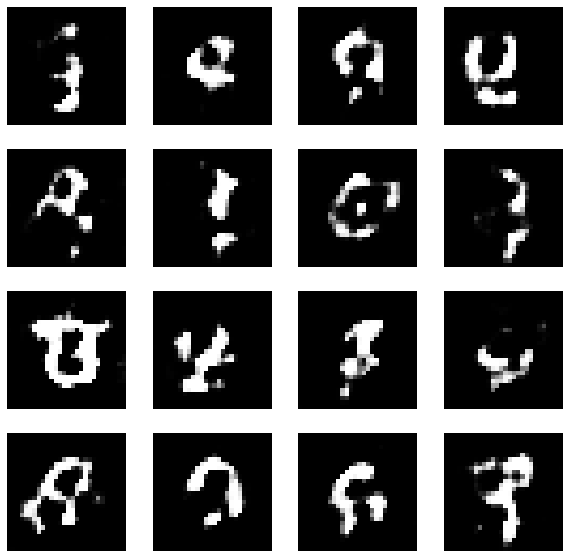

Época:  40


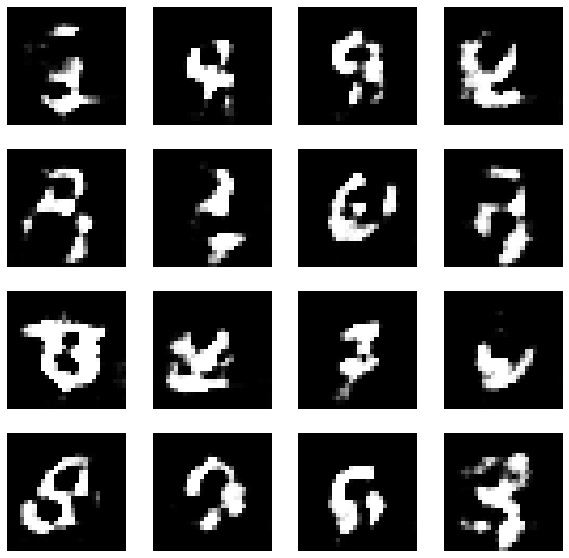

Época:  41


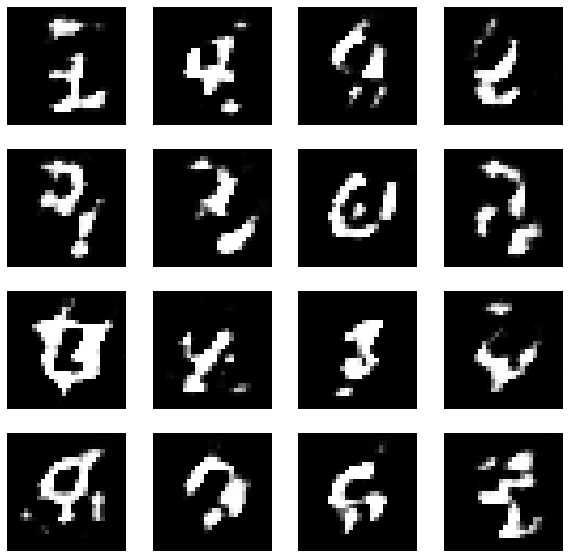

Época:  42


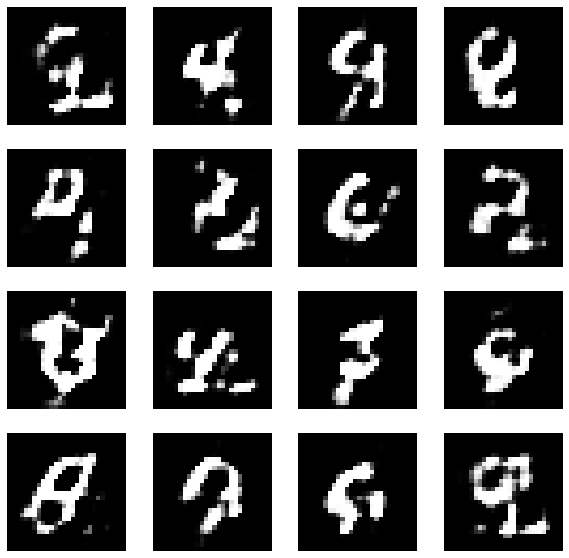

Época:  43


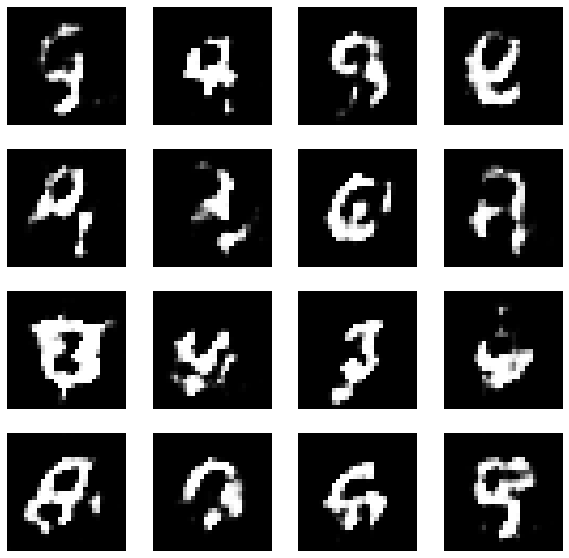

Época:  44


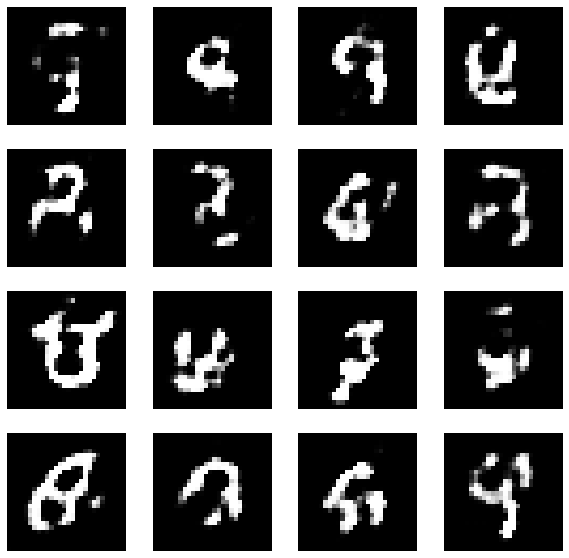

Época:  45


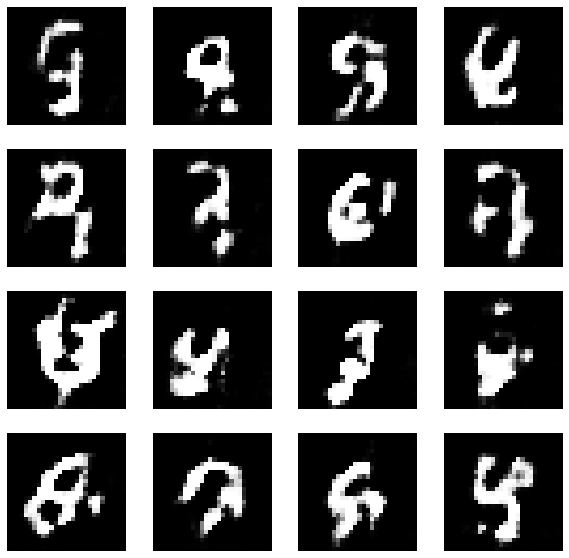

Época:  46


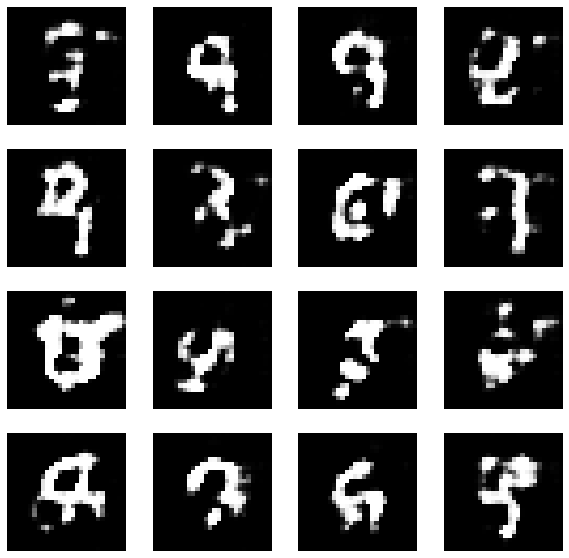

Época:  47


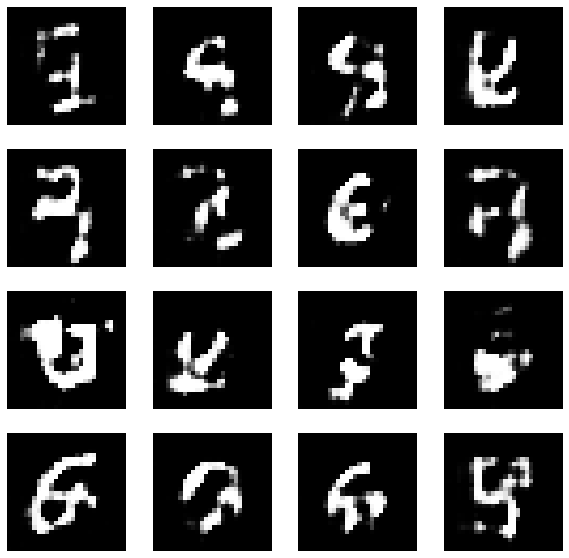

Época:  48


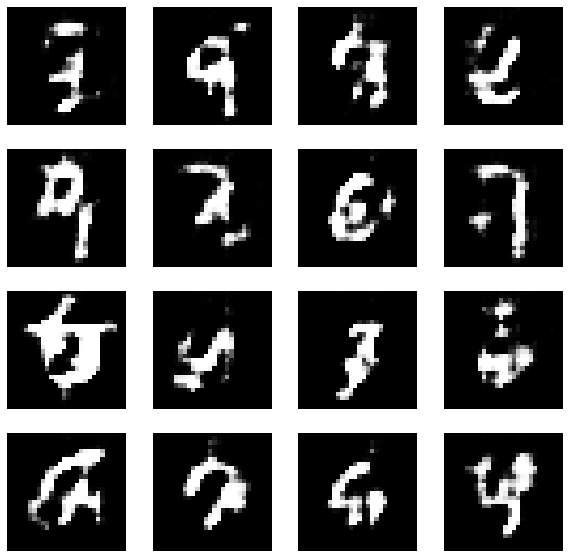

Época:  49


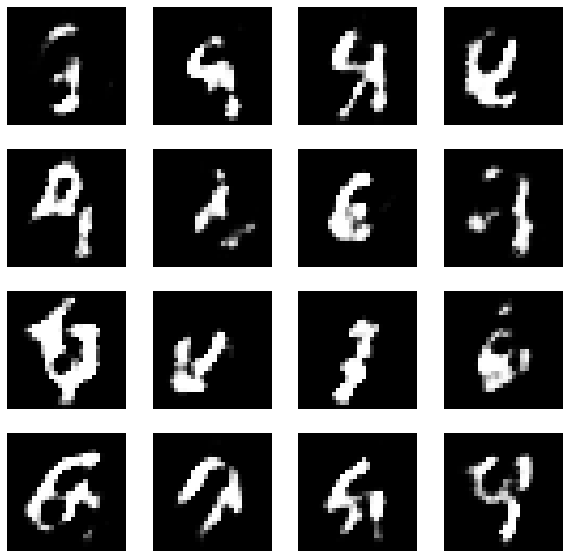

Época:  50


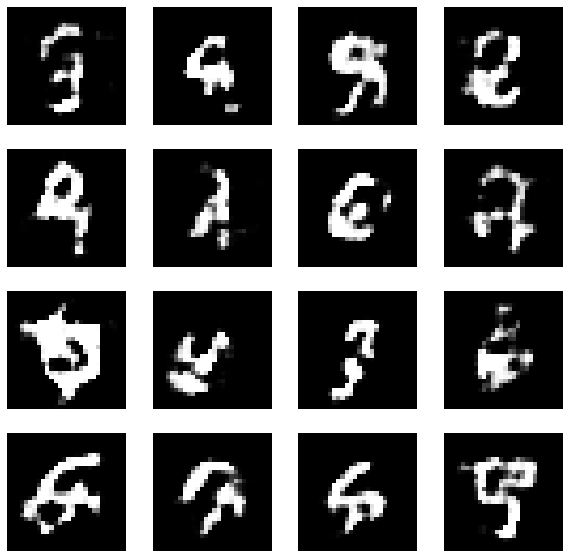

Época:  51


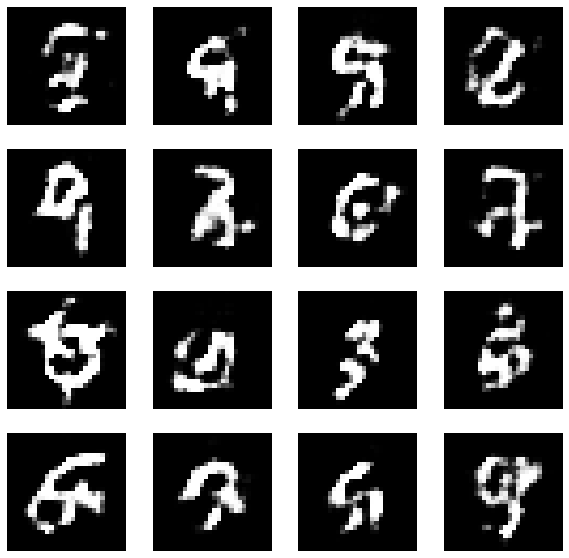

Época:  52


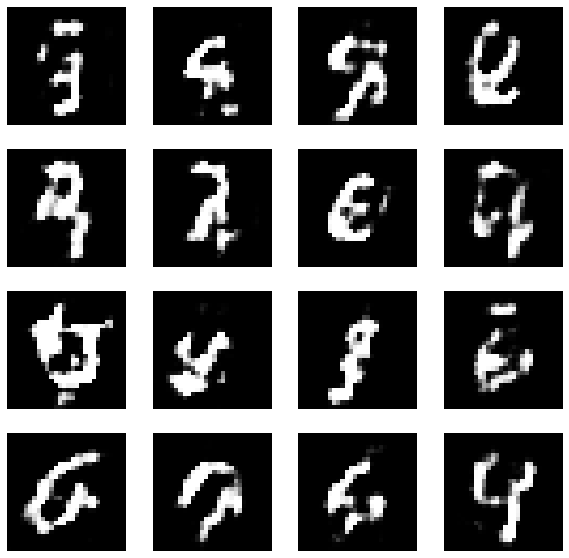

Época:  53


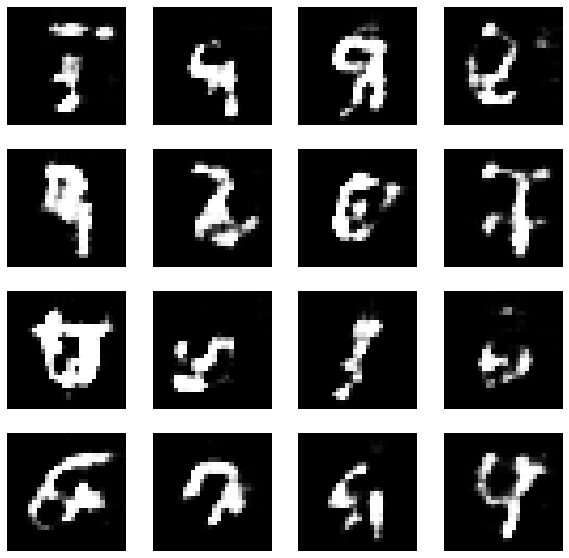

Época:  54


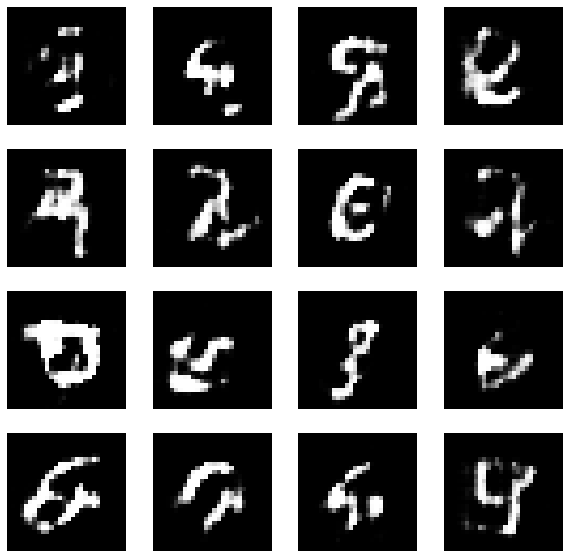

Época:  55


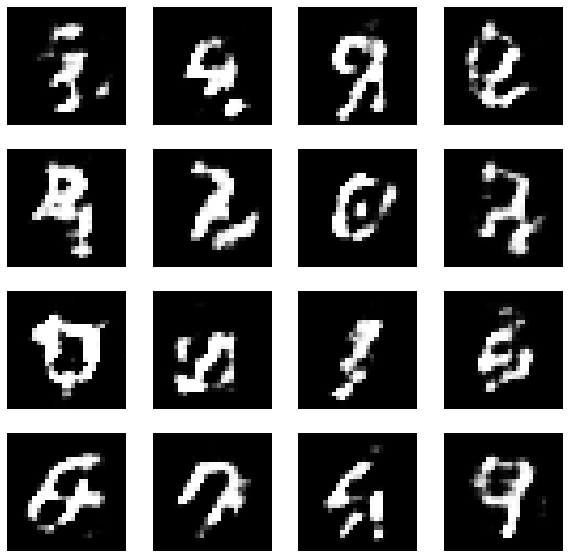

Época:  56


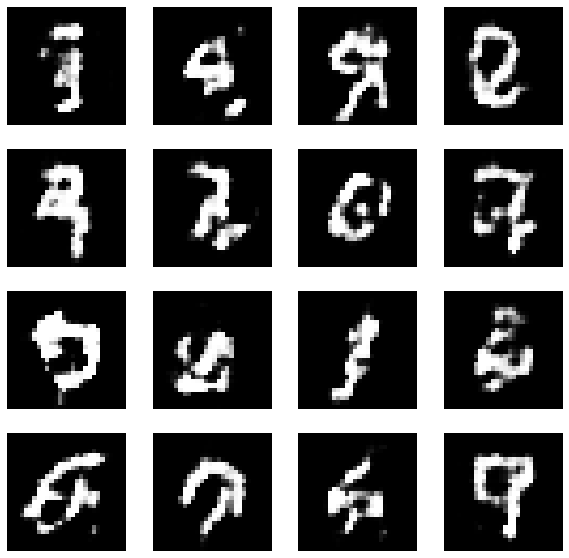

Época:  57


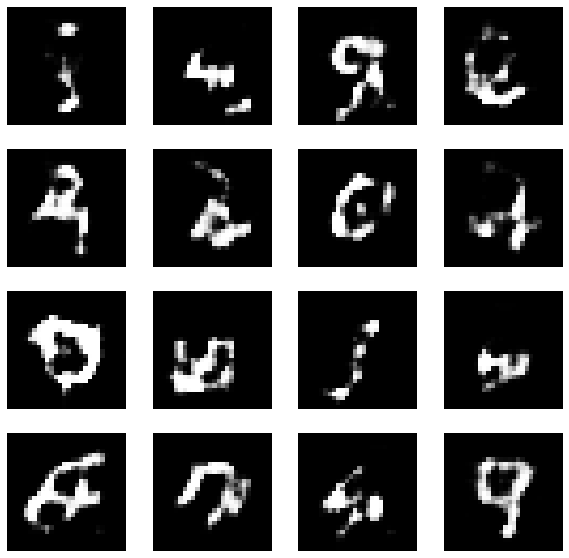

Época:  58


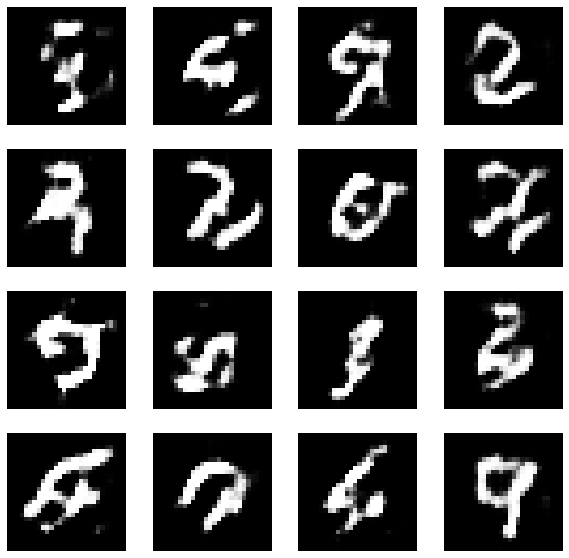

Época:  59


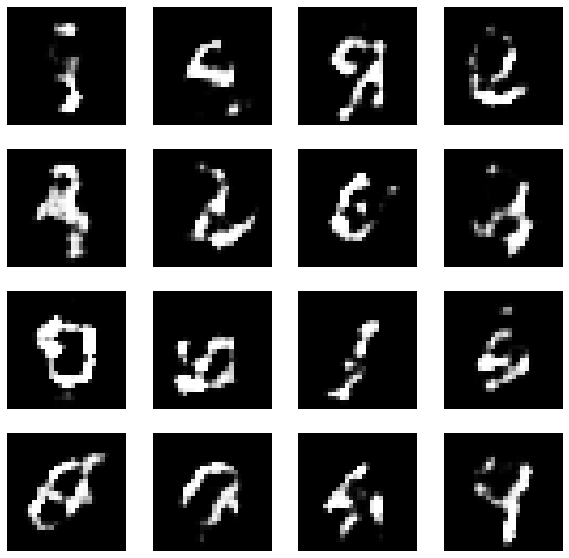

Época:  60


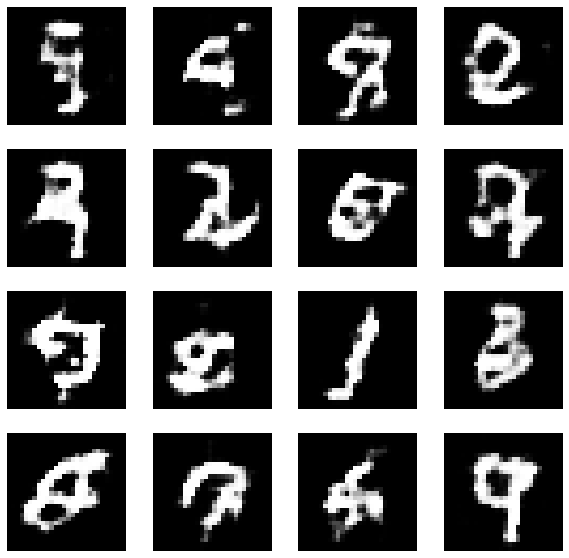

Época:  61


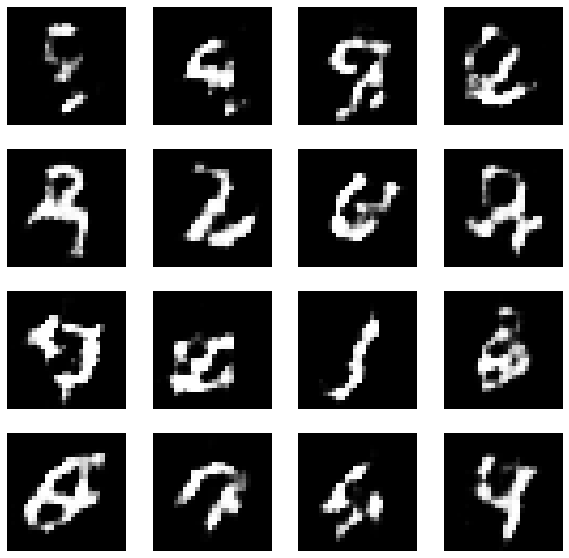

Época:  62


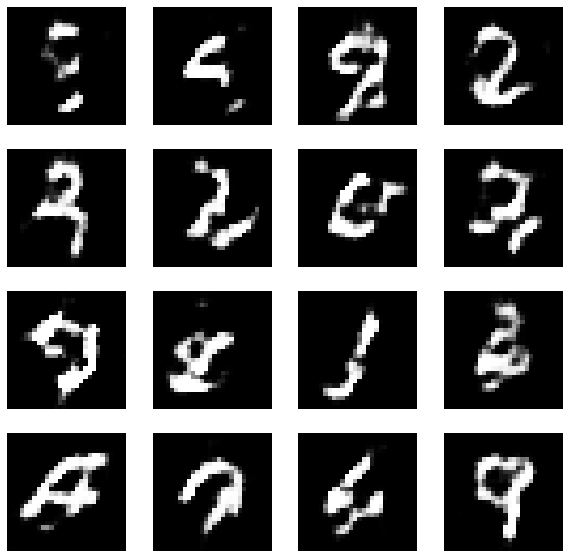

Época:  63


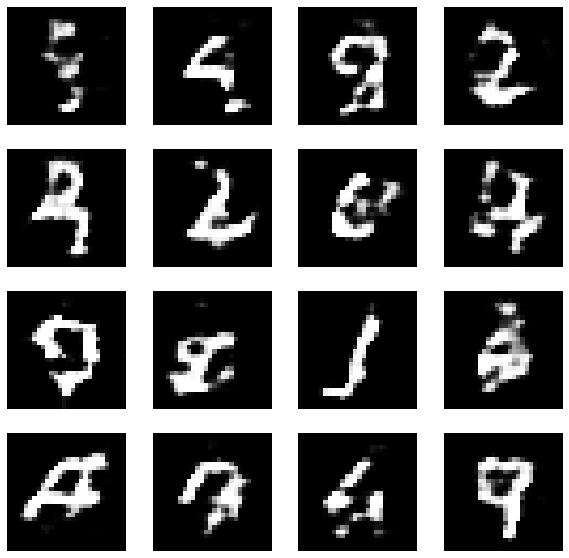

Época:  64


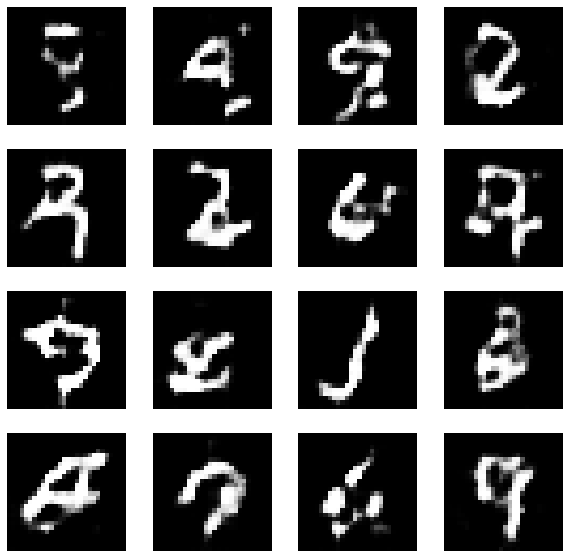

Época:  65


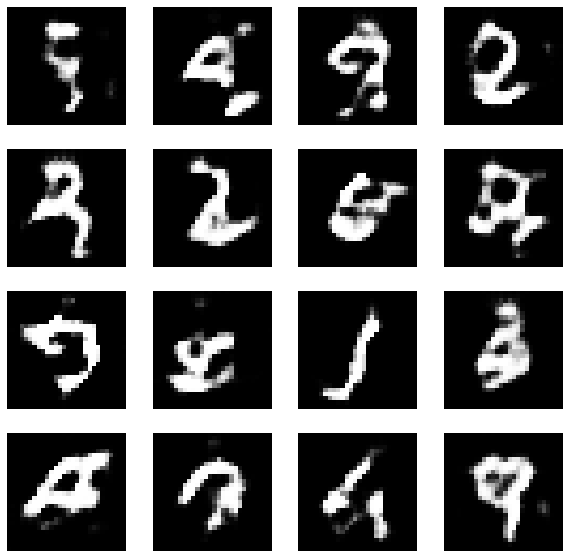

Época:  66


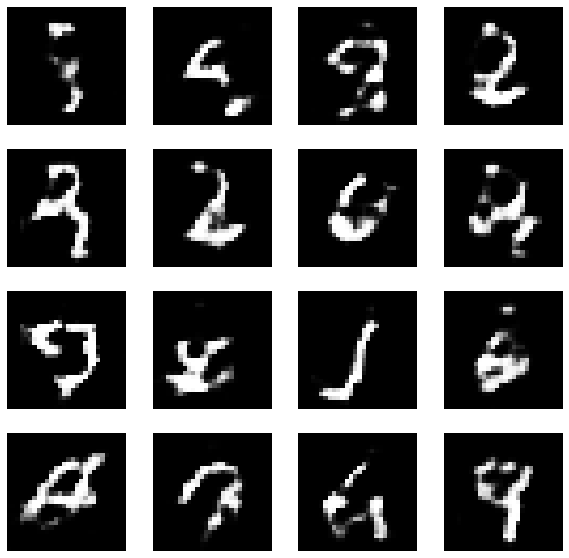

Época:  67


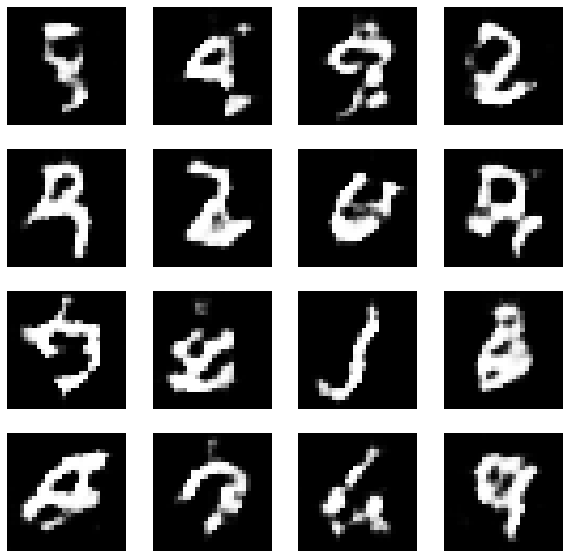

Época:  68


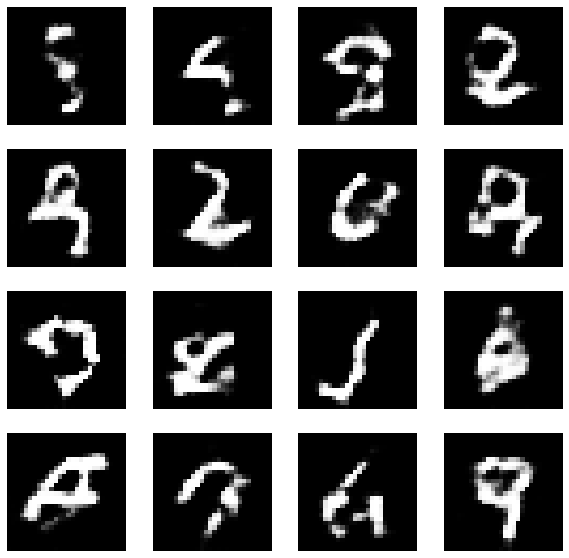

Época:  69


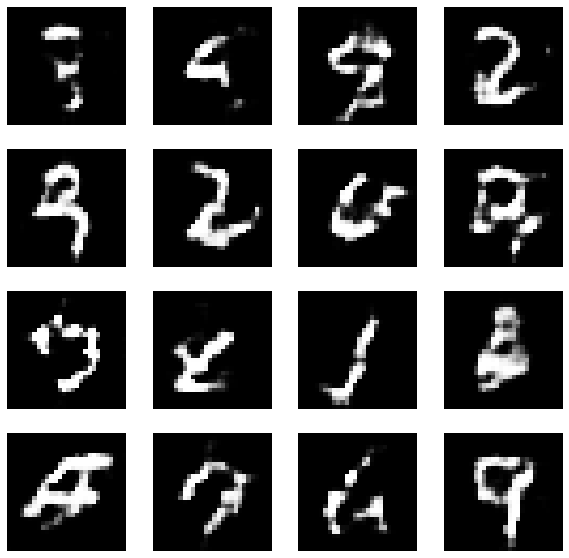

Época:  70


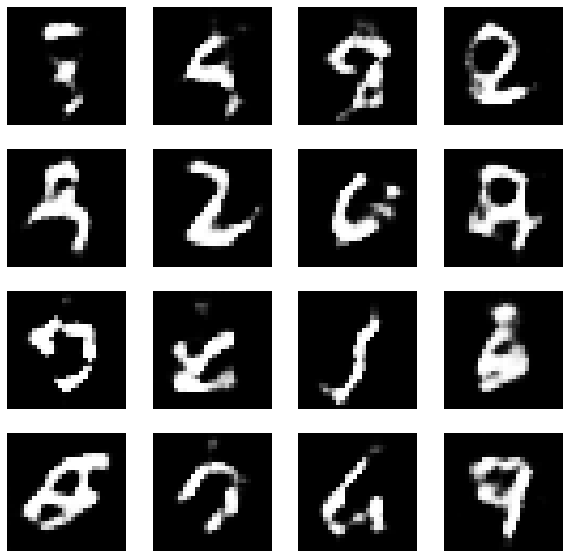

Época:  71


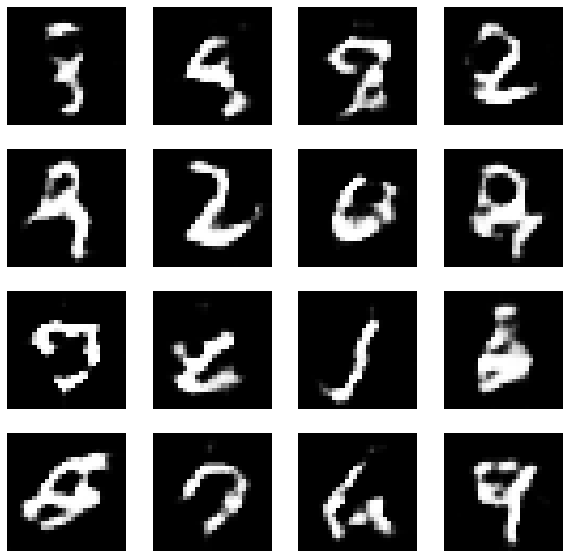

Época:  72


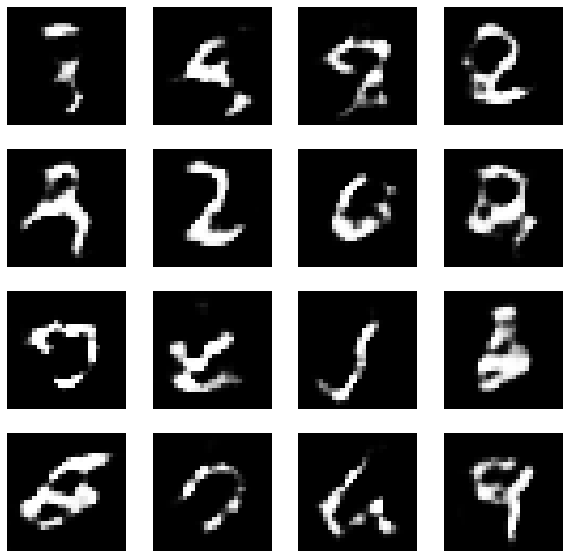

Época:  73


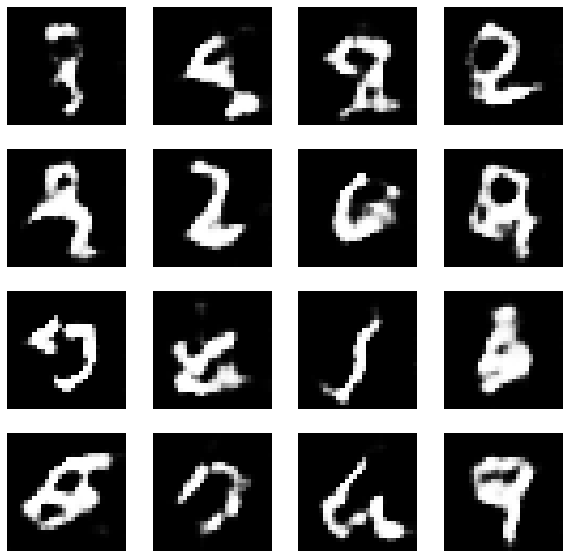

Época:  74


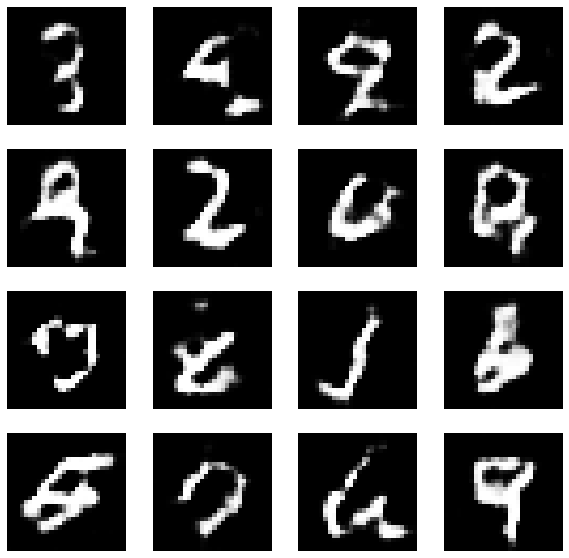

Época:  75


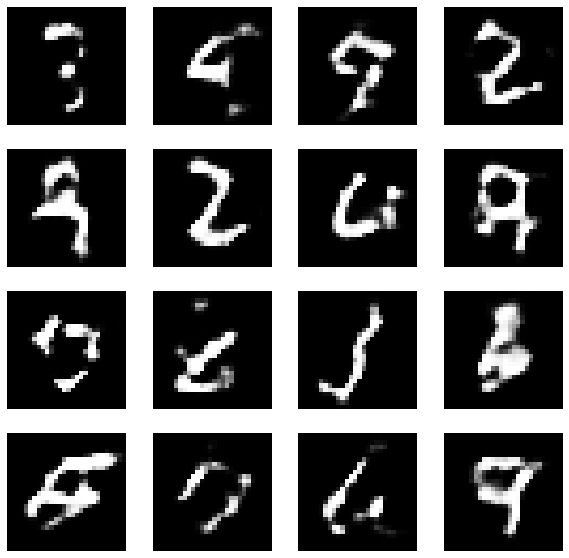

Época:  76


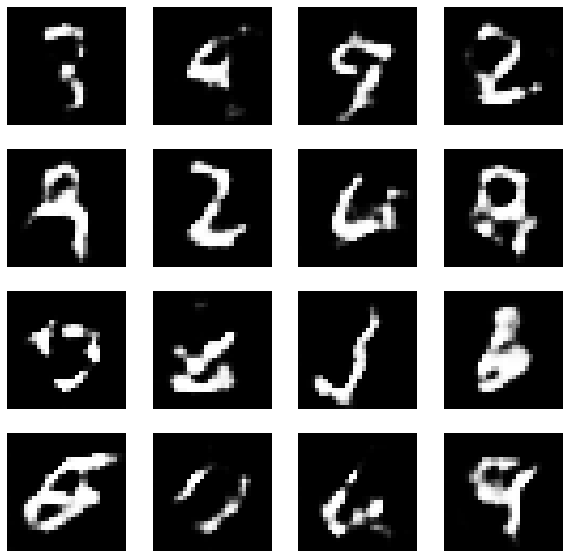

Época:  77


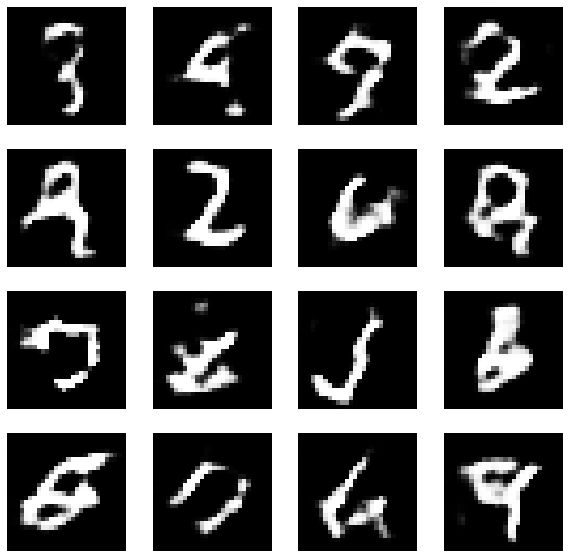

Época:  78


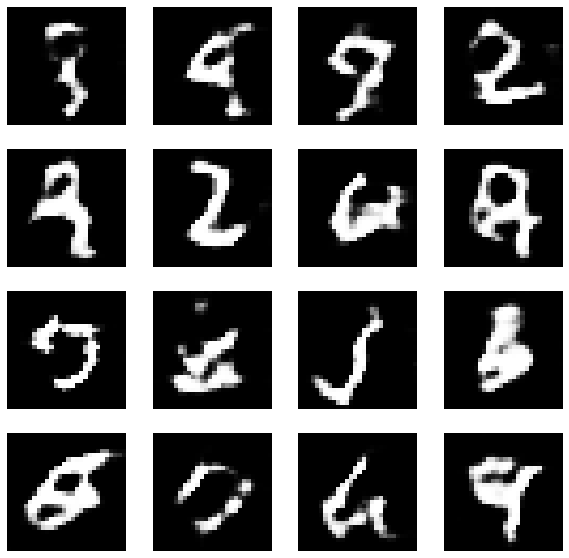

Época:  79


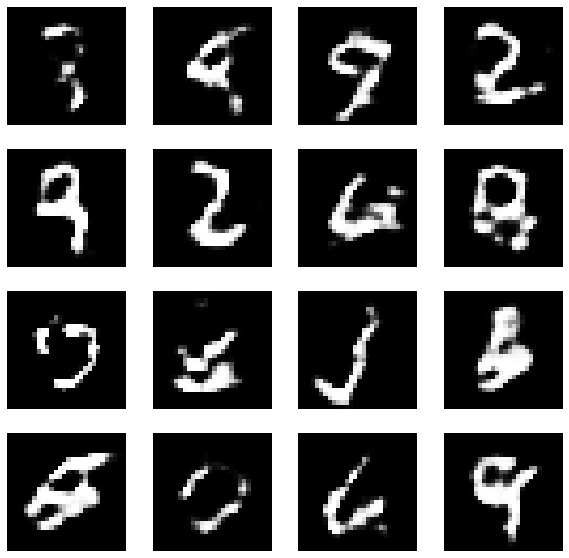

Época:  80


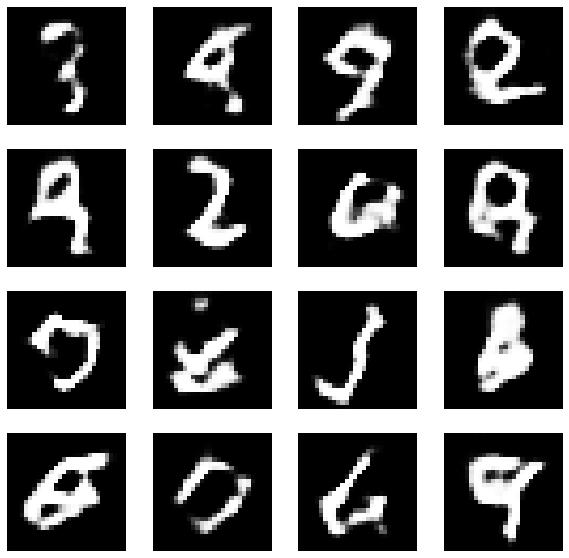

Época:  81


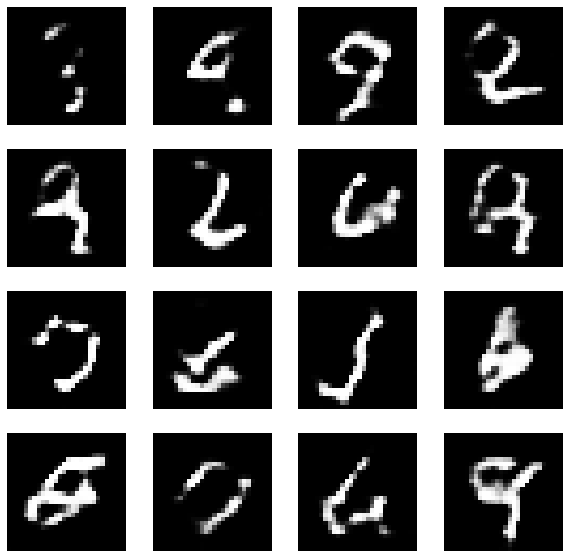

Época:  82


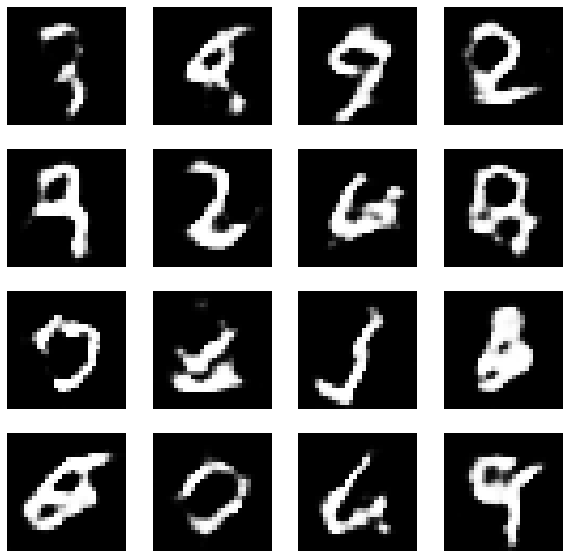

Época:  83


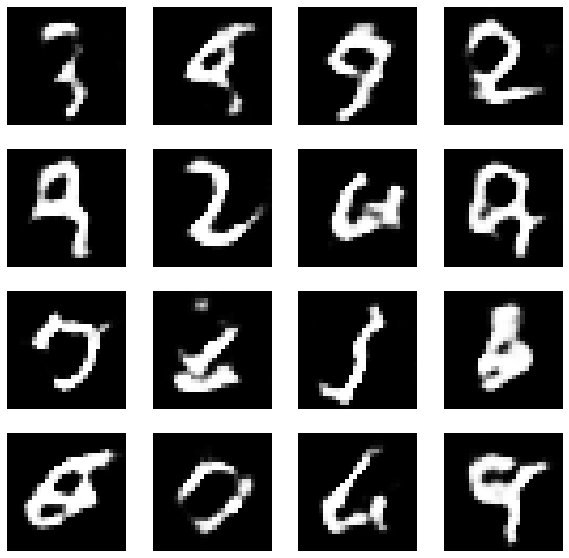

Época:  84


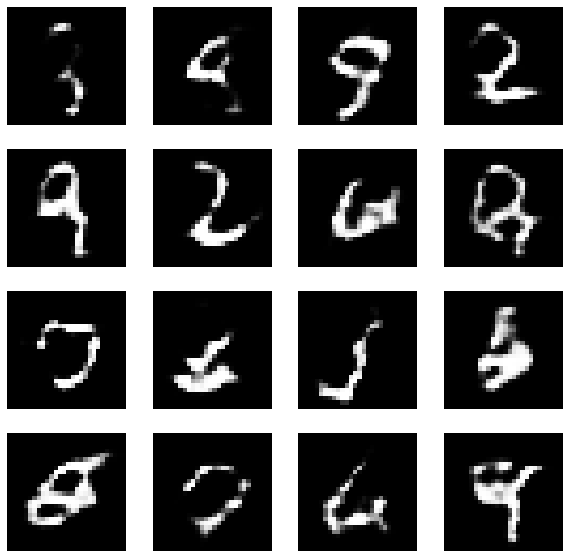

Época:  85


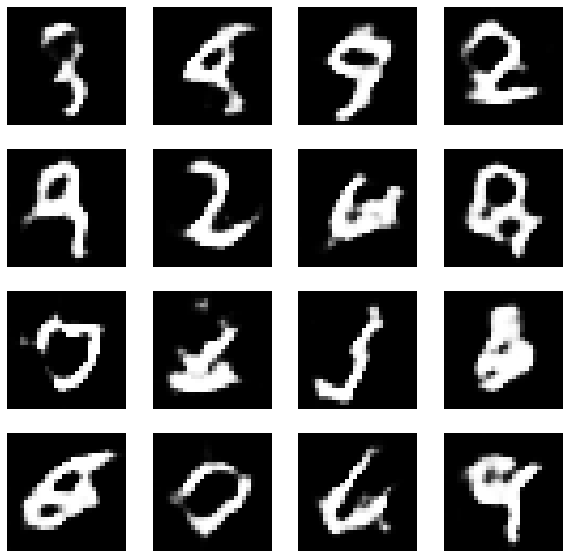

Época:  86


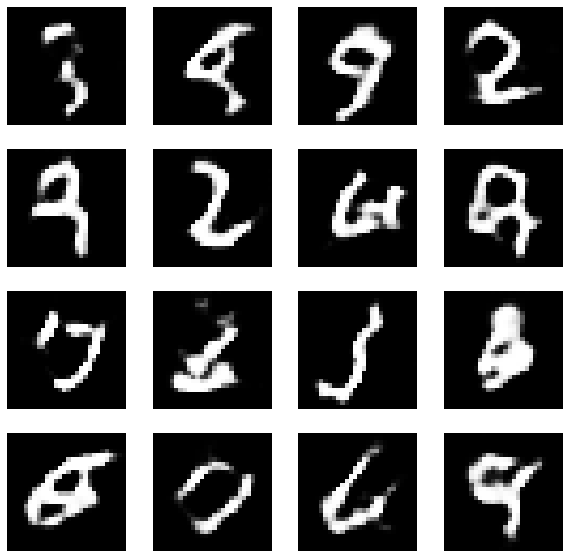

Época:  87


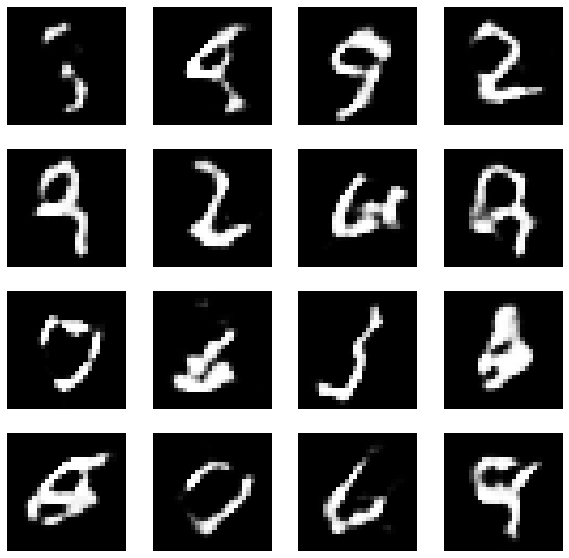

Época:  88


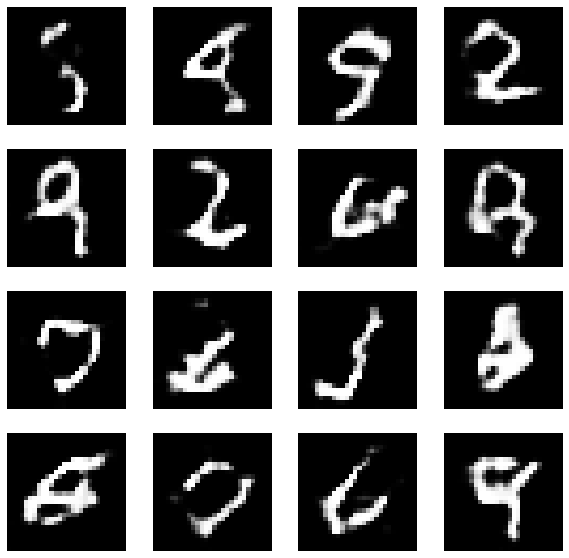

Época:  89


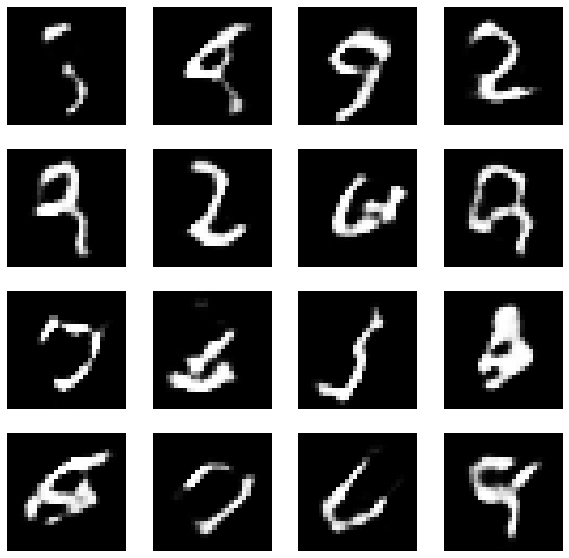

Época:  90


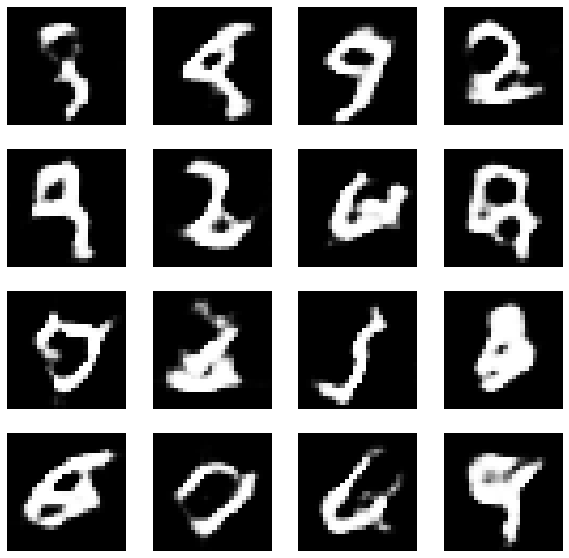

Época:  91


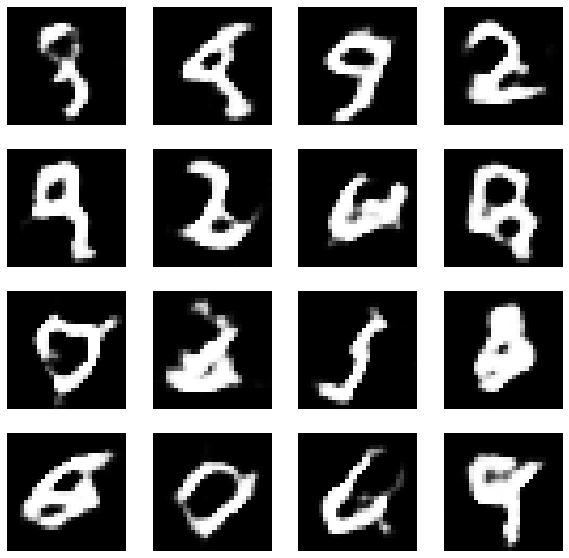

Época:  92


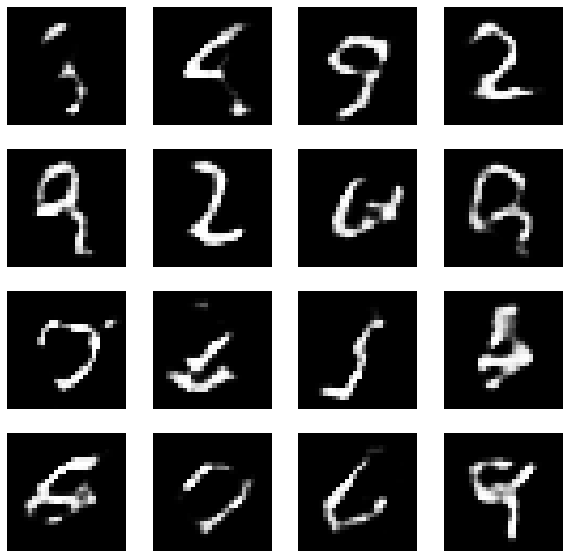

Época:  93


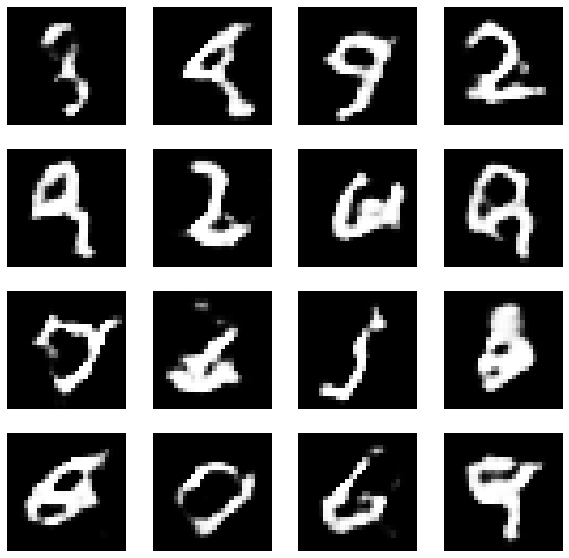

Época:  94


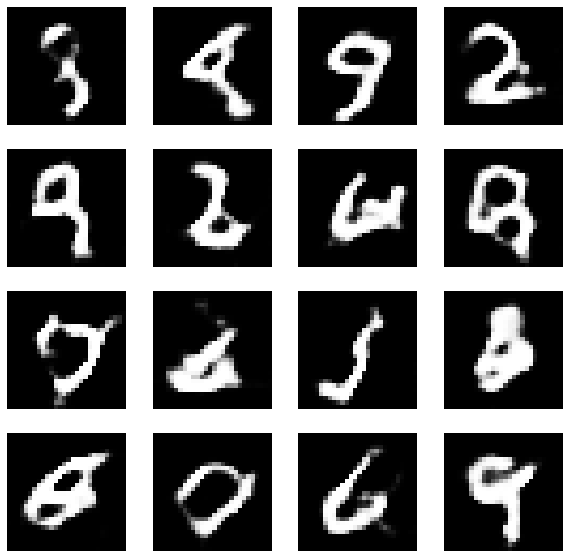

Época:  95


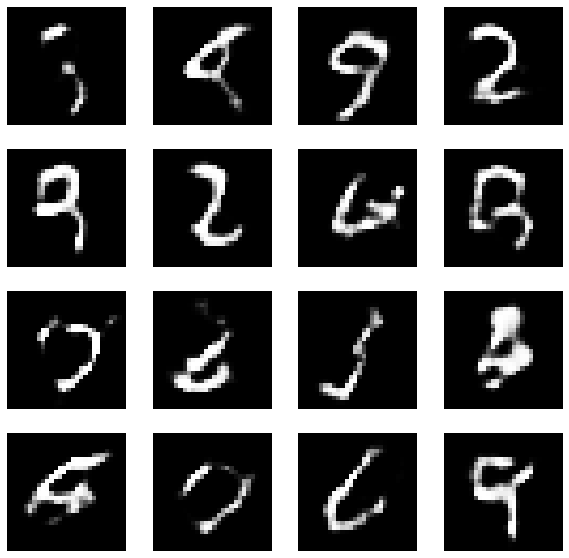

Época:  96


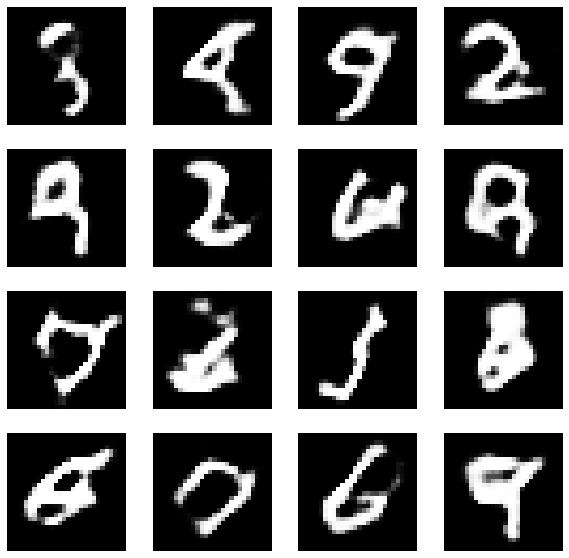

Época:  97


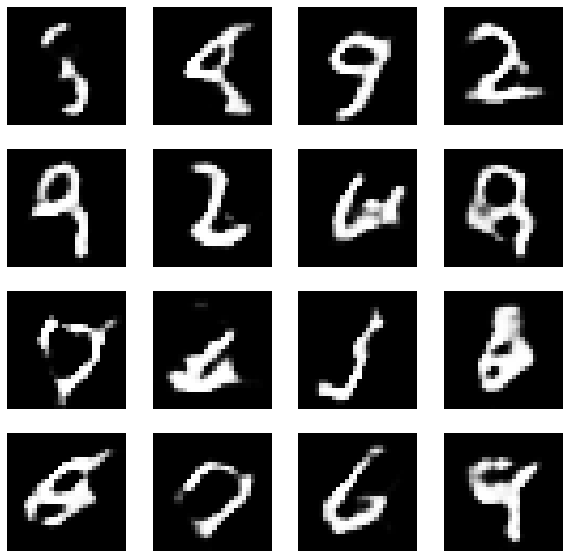

Época:  98


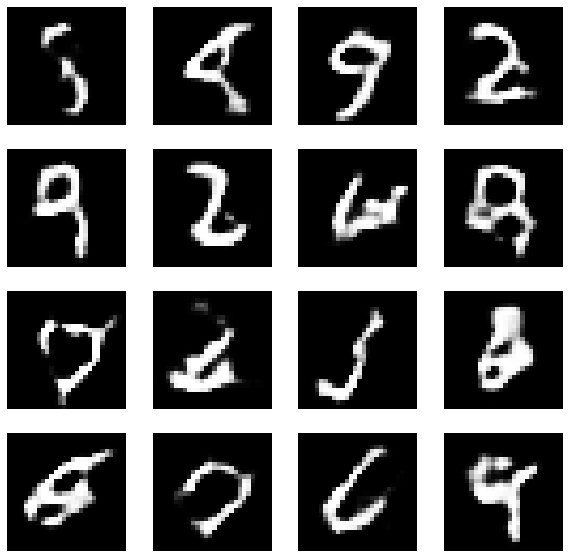

Época:  99


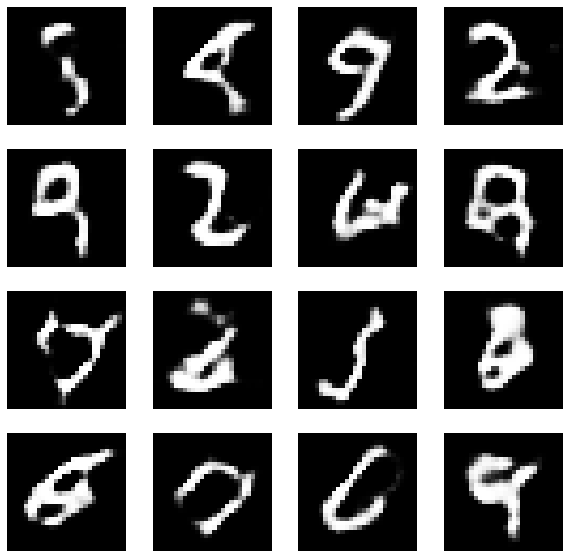

Época:  100


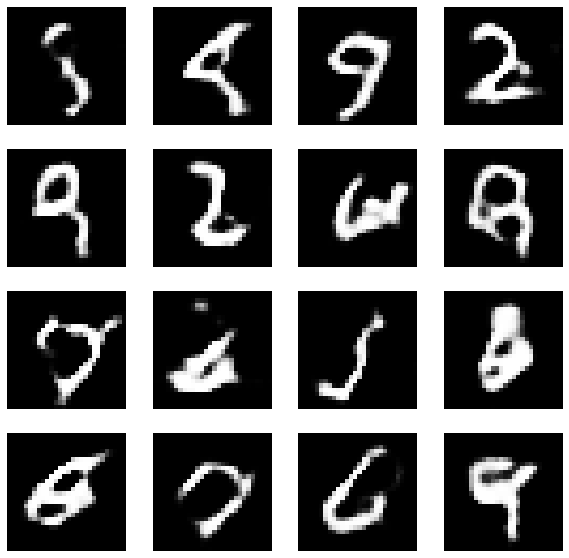

In [78]:
treinar_gran(X_treinamento, epocas, imagens_teste)